In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
from matplotlib import colors
import matplotlib.path as mpath
import cmocean

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import os

import gsw
import pyresample
from xgcm import Grid

from dask.distributed import Client
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45511/status,
Dashboard: /proxy/45511/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46673,Workers: 7
Dashboard: /proxy/45511/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:40055,Total threads: 4
Dashboard: /proxy/45289/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:34699,


In [3]:
# read grid file for lon/lat coordinates
dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
lat_rho_10km= dg.variables["lat_rho"]
lon_rho_10km = dg.variables["lon_rho"]
lat_u_10km= dg.variables["lat_u"]
lon_u_10km = dg.variables["lon_u"]
lat_v_10km= dg.variables["lat_v"]
lon_v_10km = dg.variables["lon_v"]
cor_10km = dg.variables["f"]
pm_10km = dg.variables["pm"]
pn_10km = dg.variables["pn"]
zice_10km = dg.variables["zice"]
h_10km = dg.variables["h"]
dg.close()

In [4]:
%%time

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0020.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp= ds.variables["temp"]
salt= ds.variables["salt"]
zeta= ds.variables["zeta"]
melt= ds.variables["m"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
# calc dz:
hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
z_rho = ds.zeta + (ds.zeta + hwater) * Zo_rho 
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
z_w = ds.zeta + (ds.zeta + hwater) * Zo_w 
del Zo_rho, Zo_w

ds.close()



CPU times: user 672 ms, sys: 182 ms, total: 854 ms
Wall time: 1.28 s


In [5]:
%%time

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr_ModDragA/ocean_avg_0020.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_mdA= ds.variables["temp"]
salt_mdA= ds.variables["salt"]
zeta_mdA= ds.variables["zeta"]
melt_mdA= ds.variables["m"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
# calc dz:
hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
z_rho_mdA = ds.zeta + (ds.zeta + hwater) * Zo_rho 
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
z_w_mdA = ds.zeta + (ds.zeta + hwater) * Zo_w 
del Zo_rho, Zo_w
ds.close()



CPU times: user 191 ms, sys: 10.3 ms, total: 201 ms
Wall time: 296 ms


In [6]:
%%time

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr_ModDragB/ocean_avg_0020.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_mdB= ds.variables["temp"]
salt_mdB= ds.variables["salt"]
zeta_mdB= ds.variables["zeta"]
melt_mdB= ds.variables["m"]
# calc dz:
hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
z_rho_mdB = ds.zeta + (ds.zeta + hwater) * Zo_rho 
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
z_w_mdB = ds.zeta + (ds.zeta + hwater) * Zo_w 
del Zo_rho, Zo_w
ds.close()



CPU times: user 162 ms, sys: 28.5 ms, total: 190 ms
Wall time: 336 ms


In [7]:
%%time

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr_ModDragC/ocean_avg_0020.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
# ds = xr.open_mfdataset(path_ECCO2_mdC + "ocean_avg_00*.nc")
temp_mdC= ds.variables["temp"]
salt_mdC= ds.variables["salt"]
zeta_mdC= ds.variables["zeta"]
melt_mdC= ds.variables["m"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
# calc dz:
hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
z_rho_mdC = ds.zeta + (ds.zeta + hwater) * Zo_rho 
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
z_w_mdC = ds.zeta + (ds.zeta + hwater) * Zo_w 
del Zo_rho, Zo_w
ds.close()



CPU times: user 218 ms, sys: 13.2 ms, total: 231 ms
Wall time: 395 ms


In [8]:
%%time

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr_ModDragD/ocean_avg_0020.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
# ds = xr.open_mfdataset(path_ECCO2_mdD + "ocean_avg_00*.nc")
temp_mdD= ds.variables["temp"]
salt_mdD= ds.variables["salt"]
zeta_mdD= ds.variables["zeta"]
melt_mdD= ds.variables["m"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
# calc dz:
hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
z_rho_mdD = ds.zeta + (ds.zeta + hwater) * Zo_rho 
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
z_w_mdD = ds.zeta + (ds.zeta + hwater) * Zo_w 
del Zo_rho, Zo_w
ds.close()



CPU times: user 214 ms, sys: 12.9 ms, total: 227 ms
Wall time: 392 ms


In [9]:
temp_mdD

<xarray.Variable (ocean_time: 12, s_rho: 31, eta_rho: 560, xi_rho: 630)> Size: 525MB
dask.array<open_dataset-temp, shape=(12, 31, 560, 630), dtype=float32, chunksize=(12, 31, 560, 630), chunktype=numpy.ndarray>
Attributes:
    long_name:  time-averaged potential temperature
    units:      Celsius
    time:       ocean_time
    field:      temperature, scalar, series

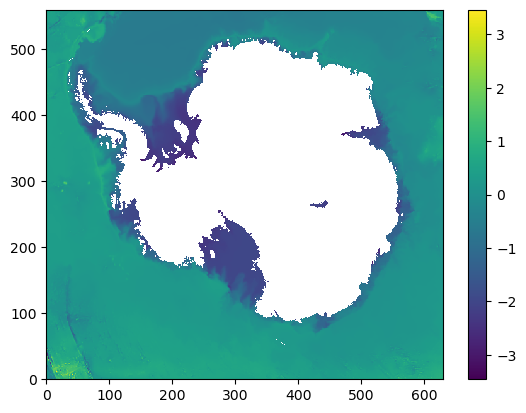

In [10]:
plt.pcolormesh(temp_mdA.isel(s_rho=0).mean('ocean_time'))
plt.colorbar()

In [11]:
mask_zice_10km = ma.masked_where(zice_10km < 0, np.ones(zice_10km.shape))
mask_outice_10km = ma.masked_where(zice_10km >= 0, np.ones(zice_10km.shape))
mask_shelf_10km = ma.masked_where(h_10km > 2000, np.ones(zice_10km.shape))


In [12]:
# load 1500 and calving front contours:
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
expt = 'WAOM10'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m')
lon_along_10km_shelf = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m')
lat_along_10km_shelf = ds.variables["two"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_10km_CF = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CalvingFront')
lat_along_10km_CF = ds.variables["two"]
ds.close()

In [13]:
fig_path='/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Maps_validations/'


# Plots temperature bottom & surface

In [14]:
temp.load()


<xarray.Variable (ocean_time: 12, s_rho: 31, eta_rho: 560, xi_rho: 630)> Size: 525MB
array([[[[0.81702286, 0.848629  , 0.88148123, ..., 0.9244975 ,
          0.9284075 , 0.9243553 ],
         [0.7854167 , 0.5306497 , 0.466126  , ..., 0.9116443 ,
          0.9148662 , 0.92030317],
         [0.7262329 , 0.49380532, 0.49728572, ..., 0.8977044 ,
          0.902003  , 0.9140067 ],
         ...,
         [1.787704  , 0.4899892 , 0.5687638 , ..., 0.37296328,
          0.38826966, 0.46293354],
         [1.8769917 , 0.5911646 , 0.5631551 , ..., 0.40320912,
          0.44639668, 0.48670313],
         [1.2253518 , 0.5737119 , 0.5303681 , ..., 0.60716444,
          0.6957325 , 0.5912178 ]],

        [[0.8150411 , 0.8259262 , 0.85343826, ..., 0.9267885 ,
          0.92938805, 0.9218891 ],
         [0.804156  , 0.5395793 , 0.47849995, ..., 0.9172836 ,
          0.9200915 , 0.9143902 ],
         [0.8596278 , 0.49446768, 0.52535546, ..., 0.8995861 ,
          0.9053712 , 0.91471094],
...
         [3.2952313 , 2.8265684 , 2.5432994 , ..., 3.5573013 ,
          3.574231  , 3.5429873 ],
         [3.03263   , 2.669929  , 2.261805  , ..., 3.9270325 ,
          3.954481  , 3.7633421 ],
         [3.2102757 , 3.3879216 , 3.1564598 , ..., 3.719091  ,
          3.6870189 , 3.7251806 ]],

        [[7.5241294 , 7.942042  , 7.7910495 , ..., 6.726917  ,
          7.0295343 , 6.9894414 ],
         [7.1062164 , 8.045489  , 7.633558  , ..., 6.605283  ,
          7.0635943 , 6.949349  ],
         [6.8656473 , 8.043698  , 7.4133444 , ..., 6.789846  ,
          7.096098  , 7.051534  ],
         ...,
         [3.245599  , 2.888911  , 2.7042902 , ..., 3.754424  ,
          3.7785149 , 4.2515955 ],
         [3.0404627 , 2.7210426 , 2.4121432 , ..., 4.200096  ,
          4.1522217 , 4.6920614 ],
         [3.3480895 , 3.6557162 , 3.461067  , ..., 4.38807   ,
          4.4376597 , 4.5648603 ]]]], dtype=float32)
Attributes:
    long_name:  time-averaged potential temperature
    units:      Celsius
    time:       ocean_time
    field:      temperature, scalar, series

In [15]:
temp_mdA.load()
temp_mdB.load()
temp_mdC.load()
temp_mdD.load()


<xarray.Variable (ocean_time: 12, s_rho: 31, eta_rho: 560, xi_rho: 630)> Size: 525MB
array([[[[0.76812226, 0.8000505 , 0.8897183 , ..., 0.92484087,
          0.9288762 , 0.9246075 ],
         [0.736194  , 0.46624348, 0.39912358, ..., 0.91212   ,
          0.91516876, 0.92033887],
         [0.6870677 , 0.42089406, 0.4232018 , ..., 0.89820147,
          0.90228045, 0.9141204 ],
         ...,
         [1.9739113 , 0.4918947 , 0.56747526, ..., 0.36578324,
          0.37466928, 0.438133  ],
         [2.1035323 , 0.592879  , 0.56341773, ..., 0.3997878 ,
          0.41286308, 0.46595463],
         [1.3398615 , 0.5761905 , 0.5282098 , ..., 0.5951863 ,
          0.62665725, 0.54630595]],

        [[0.7722506 , 0.7840225 , 0.82510084, ..., 0.92709845,
          0.92975825, 0.92212397],
         [0.7604786 , 0.47571868, 0.41134942, ..., 0.91767395,
          0.92049897, 0.9144897 ],
         [0.6877832 , 0.42107406, 0.45434138, ..., 0.9000761 ,
          0.90563107, 0.914928  ],
...
         [3.3056507 , 2.8082545 , 2.5161474 , ..., 3.5885668 ,
          3.6440022 , 3.5706284 ],
         [2.9757884 , 2.6952293 , 2.313401  , ..., 3.9352918 ,
          3.9834847 , 3.7813396 ],
         [3.1180274 , 3.2602663 , 2.9833107 , ..., 3.7137587 ,
          3.7199087 , 3.7506242 ]],

        [[7.568193  , 7.9470644 , 7.787442  , ..., 6.744892  ,
          7.029665  , 7.0002165 ],
         [7.189321  , 8.013988  , 7.6407876 , ..., 6.573508  ,
          7.051947  , 6.970768  ],
         [6.896357  , 7.9972734 , 7.4319816 , ..., 6.7994804 ,
          7.09988   , 7.046168  ],
         ...,
         [3.1900837 , 2.8682904 , 2.6764874 , ..., 3.7412734 ,
          3.8002114 , 4.276175  ],
         [3.0842717 , 2.745607  , 2.400215  , ..., 4.159025  ,
          4.147243  , 4.5736275 ],
         [3.3690195 , 3.6537676 , 3.568433  , ..., 4.353909  ,
          4.3942657 , 4.483947  ]]]], dtype=float32)
Attributes:
    long_name:  time-averaged potential temperature
    units:      Celsius
    time:       ocean_time
    field:      temperature, scalar, series

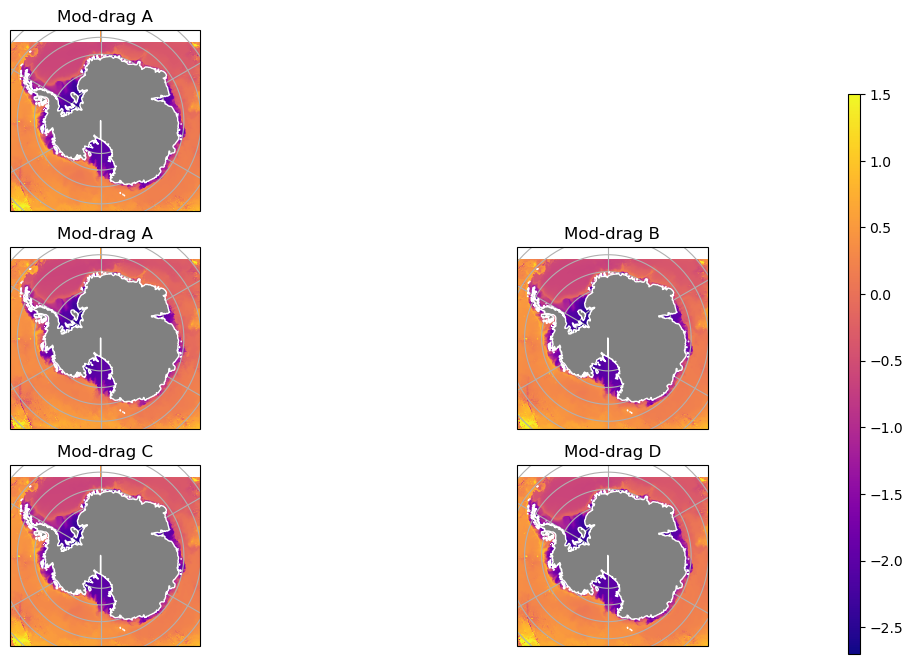

In [16]:
# call cartopy projection
proj = ccrs.SouthPolarStereo()

# ========== subregions plots:
# for 2000m isoline
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
# limits for contour of ice front (Ronne-Filchner IS):
# xlimit = np.arange(300,500,1)
# ylimit = np.arange(100,300,1)

# --- bottom

tmin = -2.7
tmax = 1.5
smin = 34.1
smax = 35.

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('Mod-drag A')
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax1 = fig.add_subplot(323, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_mdA.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('Mod-drag A')
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(324, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_mdB.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('Mod-drag B')
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax7 = fig.add_subplot(325, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_mdC.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('Mod-drag C')
ax7.gridlines() # draw_labels=True,linewidth=
# ax1.set_extent([-85, -30, -84, -74], crs=ccrs.PlateCarree())
ratio = .9
ax7.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(326, projection=proj)
##cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_mdD.isel(s_rho=0).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_mdD.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('Mod-drag D')
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax4 = fig.add_axes([0.92, 0.1, 0.01, 0.7])
fig.colorbar(cs1, cax=cbar_ax4, orientation='vertical')
cbar_ax4.set_xlabel('')#, labelpad=-35)

name_fig='waom10_ModDrag_bottomTmaps_yr20.png'
plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)


In [ ]:
# Fig 1 - paper (WAOM10)
# --- bottom T
jst= 41
jen=-1
ist=0
ien=-1

tmin = -2.7
tmax = 1
atmin = -1
atmax = 1

# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')

ax1.gridlines(draw_labels=True,linewidth=.1)
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax1.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax0 = fig.add_axes([0.48, 0.695, 0.01, 0.135])
fig.colorbar(ct1, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Temperature ($^{\circ}$C)')#, labelpad=-35)

# ModDrag A
temp_diff = (temp.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (temp_mdA.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax2 = fig.add_subplot(323, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag A')

ax2.gridlines(draw_labels=True,linewidth=.1)
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax2.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .3
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag B
temp_diff = (temp.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (temp_mdB.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax3 = fig.add_subplot(324, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag B')

ax3.gridlines(draw_labels=True,linewidth=.1)
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax3.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ratio = .3
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag C
temp_diff = (temp.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (temp_mdC.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax4 = fig.add_subplot(325, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag C')

ax4.gridlines(draw_labels=True,linewidth=.1)
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax4.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax4.get_xlim()
y_low, y_high = ax4.get_ylim()
ratio = .3
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag D
temp_diff = (temp.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (temp_mdD.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax5 = fig.add_subplot(326, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag D')

ax5.gridlines(draw_labels=True,linewidth=.1)
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax5.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ratio = .3
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.135, 0.01, 0.435])
fig.colorbar(cta, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Temperature anomalies')#, labelpad=-35)


name_fig='waom10_ModDrag_expts_bottomTmaps_yr10_PlateCarree.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


In [ ]:
# Fig 1 - paper (WAOM10)
# --- bottom T
jst= 41
jen=-1
ist=0
ien=-1

tmin = 33.5
tmax = 34.8
atmin = -.3
atmax = .3

# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   salt.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline, vmin=tmin, vmax=tmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')

ax1.gridlines(draw_labels=True,linewidth=.1)
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax1.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax0 = fig.add_axes([0.48, 0.695, 0.01, 0.135])
fig.colorbar(ct1, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Salinity')#, labelpad=-35)

# ModDrag A
salt_diff = (salt.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (salt_mdA.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax2 = fig.add_subplot(323, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   salt_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag A')

ax2.gridlines(draw_labels=True,linewidth=.1)
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax2.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .3
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag B
salt_diff = (salt.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (salt_mdB.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax3 = fig.add_subplot(324, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   salt_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag B')

ax3.gridlines(draw_labels=True,linewidth=.1)
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax3.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ratio = .3
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag C
salt_diff = (salt.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (salt_mdC.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax4 = fig.add_subplot(325, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   salt_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag C')

ax4.gridlines(draw_labels=True,linewidth=.1)
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax4.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax4.get_xlim()
y_low, y_high = ax4.get_ylim()
ratio = .3
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag D
salt_diff = (salt.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')) - (salt_mdD.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time'))
ax5 = fig.add_subplot(326, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   salt_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag D')

ax5.gridlines(draw_labels=True,linewidth=.1)
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax5.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ratio = .3
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.135, 0.01, 0.435])
fig.colorbar(cta, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Salinity anomalies')#, labelpad=-35)


name_fig='waom10_ModDrag_expts_bottomSmaps_yr10_PlateCarree.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


## basal melting

In [ ]:
# Fig 1 - paper (WAOM10)
# --- bottom T
jst= 41
jen=-1
ist=0
ien=-1

tmin = -3
tmax = 3
atmin = -1
atmax = 1

# convert m/sec to m/yr:
fac=365.25*86400

# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   melt.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')*fac, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=tmin, vmax=tmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')

ax1.gridlines(draw_labels=True,linewidth=.1)
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax1.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax0 = fig.add_axes([0.48, 0.695, 0.01, 0.135])
fig.colorbar(ct1, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Basal melt (m/yr)')#, labelpad=-35)

# ModDrag A
melt_diff = (melt.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')) - (melt_mdA.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time'))
ax2 = fig.add_subplot(323, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   # melt_diff*fac, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
                   melt_mdA.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')*fac, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=tmin, vmax=tmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag A')

ax2.gridlines(draw_labels=True,linewidth=.1)
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax2.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .3
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag B
melt_diff = (melt.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')) - (melt_mdB.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time'))
ax3 = fig.add_subplot(324, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   # melt_diff*fac, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
                   melt_mdB.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')*fac, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=tmin, vmax=tmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag B')

ax3.gridlines(draw_labels=True,linewidth=.1)
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax3.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ratio = .3
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag C
melt_diff = (melt.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')) - (melt_mdC.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time'))
ax4 = fig.add_subplot(325, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   # melt_diff*fac, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
                   melt_mdC.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')*fac, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=tmin, vmax=tmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag C')

ax4.gridlines(draw_labels=True,linewidth=.1)
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax4.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax4.get_xlim()
y_low, y_high = ax4.get_ylim()
ratio = .3
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag D
melt_diff = (melt.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')) - (melt_mdD.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time'))
ax5 = fig.add_subplot(326, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   # melt_diff*fac, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
                   melt_mdD.isel(xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')*fac, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag D')

ax5.gridlines(draw_labels=True,linewidth=.1)
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax5.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ratio = .3
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.135, 0.01, 0.435])
fig.colorbar(cta, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Basal melt')#, labelpad=-35)


name_fig='waom10_ModDrag_expts_BasalMeltmaps_yr10_PlateCarree.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


# surface:


In [ ]:
# Fig 1 - paper (WAOM10)
# --- bottom T
jst= 41
jen=-1
ist=0
ien=-1

tmin = -2.7
tmax = 1
atmin = -1
atmax = 1

# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')

ax1.gridlines(draw_labels=True,linewidth=.1)
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax1.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax0 = fig.add_axes([0.48, 0.695, 0.01, 0.135])
fig.colorbar(ct1, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Temperature ($^{\circ}$C)')#, labelpad=-35)

# ModDrag A
temp_diff = (temp.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (temp_mdA.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax2 = fig.add_subplot(323, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag A')

ax2.gridlines(draw_labels=True,linewidth=.1)
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax2.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .3
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag B
temp_diff = (temp.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (temp_mdB.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax3 = fig.add_subplot(324, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag B')

ax3.gridlines(draw_labels=True,linewidth=.1)
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax3.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ratio = .3
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag C
temp_diff = (temp.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (temp_mdC.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax4 = fig.add_subplot(325, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag C')

ax4.gridlines(draw_labels=True,linewidth=.1)
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax4.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax4.get_xlim()
y_low, y_high = ax4.get_ylim()
ratio = .3
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag D
temp_diff = (temp.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (temp_mdD.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax5 = fig.add_subplot(326, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag D')

ax5.gridlines(draw_labels=True,linewidth=.1)
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax5.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ratio = .3
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.135, 0.01, 0.435])
fig.colorbar(cta, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Temperature anomalies')#, labelpad=-35)


name_fig='waom10_ModDrag_expts_sfcTmaps_yr10_PlateCarree.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


In [ ]:
# Fig 1 - paper (WAOM10)
# --- bottom T
jst= 41
jen=-1
ist=0
ien=-1

tmin = 33.5
tmax = 34.8
atmin = -.3
atmax = .3

# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   salt.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')

ax1.gridlines(draw_labels=True,linewidth=.1)
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax1.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax0 = fig.add_axes([0.48, 0.695, 0.01, 0.135])
fig.colorbar(ct1, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Salinity')#, labelpad=-35)

# ModDrag A
salt_diff = (salt.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (salt_mdA.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax2 = fig.add_subplot(323, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   salt_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag A')

ax2.gridlines(draw_labels=True,linewidth=.1)
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax2.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .3
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag B
salt_diff = (salt.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (salt_mdB.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax3 = fig.add_subplot(324, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   salt_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag B')

ax3.gridlines(draw_labels=True,linewidth=.1)
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax3.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ratio = .3
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag C
salt_diff = (salt.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (salt_mdC.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax4 = fig.add_subplot(325, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   salt_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag C')

ax4.gridlines(draw_labels=True,linewidth=.1)
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax4.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax4.get_xlim()
y_low, y_high = ax4.get_ylim()
ratio = .3
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ModDrag D
salt_diff = (salt.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (salt_mdD.isel(s_rho=-1,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax5 = fig.add_subplot(326, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   salt_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag D')

ax5.gridlines(draw_labels=True,linewidth=.1)
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax5.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ratio = .3
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.135, 0.01, 0.435])
fig.colorbar(cta, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Salinity anomalies')#, labelpad=-35)


name_fig='waom10_ModDrag_expts_sfcSmaps_yr10_PlateCarree.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


# Do cross-sections using interpolated sections (per longitude). Can I create a function to use it instead?


In [29]:
np.ceil(30/0.2)

150.0

In [31]:
%%time


def extract_merid_section(longitude,tracer_var,z_var): # longitude could be between -180:180

    # 1) create vector (using lat.min:lat.max; then apply mask to remove values north of the 1500m isobath)
    # vector should have same resolution as the original data (to minimise errors due to non-exact zonal transect)

    minlat = -90
    maxlat = -60

    # lat_maxpts = np.ceil(30/0.091985) # took 3.5min
    lat_maxpts = np.ceil(30/0.5) # took 
    lat_vector = np.linspace(minlat,maxlat,num=int(lat_maxpts))

    lon=longitude # west of PIT trough
    lon_vector = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping

    # Create a meshgrid from the longitude and latitude vectors
    lon_mesh, lat_mesh = np.meshgrid(lon_vector, lat_vector)


    # Create a new DataArray for the vector
    vector_da = xr.DataArray(
        np.zeros_like(lon_mesh),  # Placeholder values (will be overwritten)
        dims=['lat_rho', 'lon_rho'],
        coords={'lat_rho': lat_vector, 'lon_rho': lon_vector}
    )

    ##re-grid high-res zice/h to 10km grid:
    w10_def = pyresample.geometry.SwathDefinition(lons=lon_rho_10km,lats=lat_rho_10km)
    w10u_def = pyresample.geometry.SwathDefinition(lons=lon_u_10km,lats=lat_u_10km)
    w10v_def = pyresample.geometry.SwathDefinition(lons=lon_v_10km,lats=lat_v_10km)
    transect_def = pyresample.geometry.SwathDefinition(lons=vector_da.lon_rho,lats=vector_da.lat_rho)
    wf = lambda r: 1/r

    h_merid_transect = pyresample.kd_tree.resample_custom(w10_def,h_10km.values,transect_def,\
                                             radius_of_influence=10000,neighbours=4,weight_funcs=wf)

    ## Find the index of the last point before depth >= 1500m -> to plot/calc only on the shelf --> NOT using this
    last_pt_ind = np.where(h_merid_transect >= 1500)[0][0] - 1
    last_pt_dep = h_merid_transect[last_pt_ind]
    # The first point before depth > 500m
    first_pt_ind = np.where(h_merid_transect > 50)[0][0] -1
    first_pt_dep = h_merid_transect[first_pt_ind]

    temp_merid_transect = np.empty((12,31,len(lon_vector)))
    Hz_merid_transect = np.empty((12,31,len(lon_vector)))

    lat_31lev = np.empty(Hz_merid_transect[0,:,:].shape)
    for zz in range(31):
        lat_31lev[zz,:] = vector_da.lat_rho

    for tt in range(0,12):
        for zz in range(0,31):
            temp_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,tracer_var.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                             radius_of_influence=10000,neighbours=4,weight_funcs=wf)
            Hz_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,z_var.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                             radius_of_influence=10000,neighbours=4,weight_funcs=wf)

    return lat_31lev, temp_merid_transect, Hz_merid_transect

lat_31lev_Lon105W, temp_merid_transect_Lon105W, Hz_merid_transec_Lon105W = extract_merid_section(-105,temp,z_rho)

CPU times: user 1min 46s, sys: 6.83 s, total: 1min 53s
Wall time: 4min 23s


## running for all ModDrag expts:

AmudS

In [32]:
%%time
lat_31lev_Lon105W, temp_mdA_merid_transect_Lon105W, Hz_mdA_merid_transec_Lon105W = extract_merid_section(-105,temp_mdA,z_rho_mdA)
lat_31lev_Lon105W, temp_mdB_merid_transect_Lon105W, Hz_mdB_merid_transec_Lon105W = extract_merid_section(-105,temp_mdB,z_rho_mdB)
lat_31lev_Lon105W, temp_mdC_merid_transect_Lon105W, Hz_mdC_merid_transec_Lon105W = extract_merid_section(-105,temp_mdC,z_rho_mdC)
lat_31lev_Lon105W, temp_mdD_merid_transect_Lon105W, Hz_mdD_merid_transec_Lon105W = extract_merid_section(-105,temp_mdD,z_rho_mdD)

CPU times: user 10min 57s, sys: 57.7 s, total: 11min 54s
Wall time: 56min 27s


In [ ]:
%%time
lat_31lev_Lon115W, temp_merid_transect_Lon115W, Hz_merid_transec_Lon115W = extract_merid_section(-115,temp,z_rho)
lat_31lev_Lon115W, temp_mdA_merid_transect_Lon115W, Hz_mdA_merid_transec_Lon115W = extract_merid_section(-115,temp_mdA,z_rho_mdA)
lat_31lev_Lon115W, temp_mdB_merid_transect_Lon115W, Hz_mdB_merid_transec_Lon115W = extract_merid_section(-115,temp_mdB,z_rho_mdB)
lat_31lev_Lon115W, temp_mdC_merid_transect_Lon115W, Hz_mdC_merid_transec_Lon115W = extract_merid_section(-115,temp_mdC,z_rho_mdC)
lat_31lev_Lon115W, temp_mdD_merid_transect_Lon115W, Hz_mdD_merid_transec_Lon115W = extract_merid_section(-115,temp_mdD,z_rho_mdD)

BellS

In [ ]:
%%time
# 80W, 95W

lat_31lev_Lon80W, temp_merid_transect_Lon80W, Hz_merid_transec_Lon80W = extract_merid_section(-80,temp,z_rho)
lat_31lev_Lon80W, temp_mdA_merid_transect_Lon80W, Hz_mdA_merid_transec_Lon80W = extract_merid_section(-80,temp_mdA,z_rho_mdA)
lat_31lev_Lon80W, temp_mdB_merid_transect_Lon80W, Hz_mdB_merid_transec_Lon80W = extract_merid_section(-80,temp_mdB,z_rho_mdB)
lat_31lev_Lon80W, temp_mdC_merid_transect_Lon80W, Hz_mdC_merid_transec_Lon80W = extract_merid_section(-80,temp_mdC,z_rho_mdC)
lat_31lev_Lon80W, temp_mdD_merid_transect_Lon80W, Hz_mdD_merid_transec_Lon80W = extract_merid_section(-80,temp_mdD,z_rho_mdD)

In [ ]:
%%time
lat_31lev_Lon95W, temp_merid_transect_Lon95W, Hz_merid_transec_Lon95W = extract_merid_section(-95,temp,z_rho)
lat_31lev_Lon95W, temp_mdA_merid_transect_Lon95W, Hz_mdA_merid_transec_Lon95W = extract_merid_section(-95,temp_mdA,z_rho_mdA)
lat_31lev_Lon95W, temp_mdB_merid_transect_Lon95W, Hz_mdB_merid_transec_Lon95W = extract_merid_section(-95,temp_mdB,z_rho_mdB)
lat_31lev_Lon95W, temp_mdC_merid_transect_Lon95W, Hz_mdC_merid_transec_Lon95W = extract_merid_section(-95,temp_mdC,z_rho_mdC)
lat_31lev_Lon95W, temp_mdD_merid_transect_Lon95W, Hz_mdD_merid_transec_Lon95W = extract_merid_section(-95,temp_mdD,z_rho_mdD)

Ross

In [ ]:
#Ross 158, 165W
%%time
lat_31lev_Lon158W, temp_merid_transect_Lon158W, Hz_merid_transec_Lon158W = extract_merid_section(-158,temp,z_rho)
lat_31lev_Lon158W, temp_mdA_merid_transect_Lon158W, Hz_mdA_merid_transec_Lon158W = extract_merid_section(-158,temp_mdA,z_rho_mdA)
lat_31lev_Lon158W, temp_mdB_merid_transect_Lon158W, Hz_mdB_merid_transec_Lon158W = extract_merid_section(-158,temp_mdB,z_rho_mdB)
lat_31lev_Lon158W, temp_mdC_merid_transect_Lon158W, Hz_mdC_merid_transec_Lon158W = extract_merid_section(-158,temp_mdC,z_rho_mdC)
lat_31lev_Lon158W, temp_mdD_merid_transect_Lon158W, Hz_mdD_merid_transec_Lon158W = extract_merid_section(-158,temp_mdD,z_rho_mdD)

In [ ]:
%%time
lat_31lev_Lon165W, temp_merid_transect_Lon165W, Hz_merid_transec_Lon165W = extract_merid_section(-165,temp,z_rho)
lat_31lev_Lon165W, temp_mdA_merid_transect_Lon165W, Hz_mdA_merid_transec_Lon165W = extract_merid_section(-165,temp_mdA,z_rho_mdA)
lat_31lev_Lon165W, temp_mdB_merid_transect_Lon165W, Hz_mdB_merid_transec_Lon165W = extract_merid_section(-165,temp_mdB,z_rho_mdB)
lat_31lev_Lon165W, temp_mdC_merid_transect_Lon165W, Hz_mdC_merid_transec_Lon165W = extract_merid_section(-165,temp_mdC,z_rho_mdC)
lat_31lev_Lon165W, temp_mdD_merid_transect_Lon165W, Hz_mdD_merid_transec_Lon165W = extract_merid_section(-165,temp_mdD,z_rho_mdD)

In [ ]:
# below code to do plotting. Adapt for results to compare across resolution.

Text(0.5, 1.0, 'Longitude 158W')

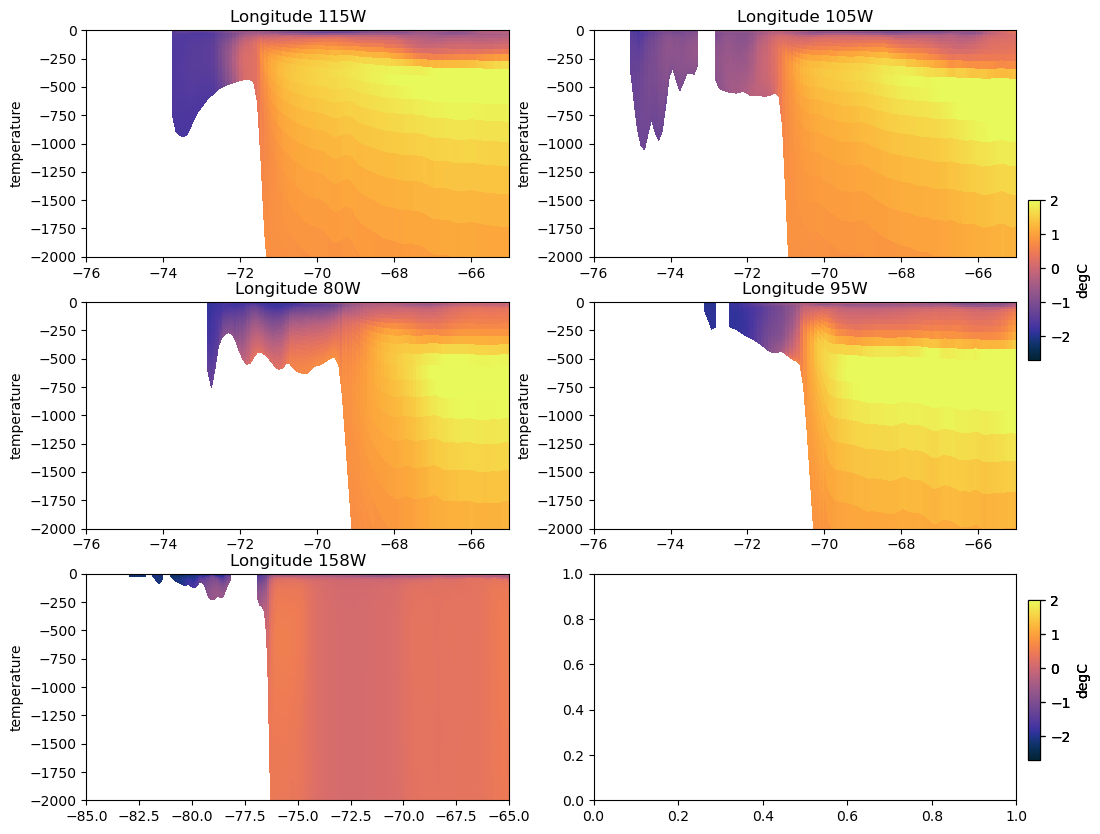

In [102]:
tmin=-2.7
tmax=2


fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (12, 10))

ct=ax[0,0].pcolor(lat_31lev_Lon115W,np.nanmean(Hz_merid_transect_Lon115W,axis=0),np.nanmean(temp_merid_transect_Lon115W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
cbar_ax0= fig.add_axes([0.91, 0.55,  0.01, 0.16])
fig.colorbar(ct, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('degC')#, labelpad=-35)
ax[0,0].set_ylabel('temperature')
ax[0,0].set_ylim(-2000,0)
ax[0,0].set_xlim(-76,-65)
ax[0,0].set_title('Longitude 115W')

ct=ax[0,1].pcolor(lat_31lev_Lon105W,np.nanmean(Hz_merid_transect_Lon105W,axis=0),np.nanmean(temp_merid_transect_Lon105W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
cbar_ax1= fig.add_axes([0.91, 0.15,  0.01, 0.16])
fig.colorbar(ct, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('degC')#, labelpad=-35)
ax[0,1].set_ylabel('temperature')
ax[0,1].set_ylim(-2000,0)
ax[0,1].set_xlim(-76,-65)
ax[0,1].set_title('Longitude 105W')

ct=ax[1,0].pcolor(lat_31lev_Lon80W,np.nanmean(Hz_merid_transect_Lon80W,axis=0),np.nanmean(temp_merid_transect_Lon80W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
cbar_ax0= fig.add_axes([0.91, 0.55,  0.01, 0.16])
fig.colorbar(ct, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('degC')#, labelpad=-35)
ax[1,0].set_ylabel('temperature')
ax[1,0].set_ylim(-2000,0)
ax[1,0].set_xlim(-76,-65)
ax[1,0].set_title('Longitude 80W')

ct=ax[1,1].pcolor(lat_31lev_Lon95W,np.nanmean(Hz_merid_transect_Lon95W,axis=0),np.nanmean(temp_merid_transect_Lon95W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
cbar_ax1= fig.add_axes([0.91, 0.15,  0.01, 0.16])
fig.colorbar(ct, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('degC')#, labelpad=-35)
ax[1,1].set_ylabel('temperature')
ax[1,1].set_ylim(-2000,0)
ax[1,1].set_xlim(-76,-65)
ax[1,1].set_title('Longitude 95W')

ct=ax[2,0].pcolor(lat_31lev_Lon158W,np.nanmean(Hz_merid_transect_Lon158W,axis=0),np.nanmean(temp_merid_transect_Lon158W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
cbar_ax1= fig.add_axes([0.91, 0.15,  0.01, 0.16])
fig.colorbar(ct, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('degC')#, labelpad=-35)
ax[2,0].set_ylabel('temperature')
ax[2,0].set_ylim(-2000,0)
ax[2,0].set_xlim(-85,-65)
ax[2,0].set_title('Longitude 158W')


## WHY NO CAVITY? 1. could be DZT calc, 2. could be Hz interp 

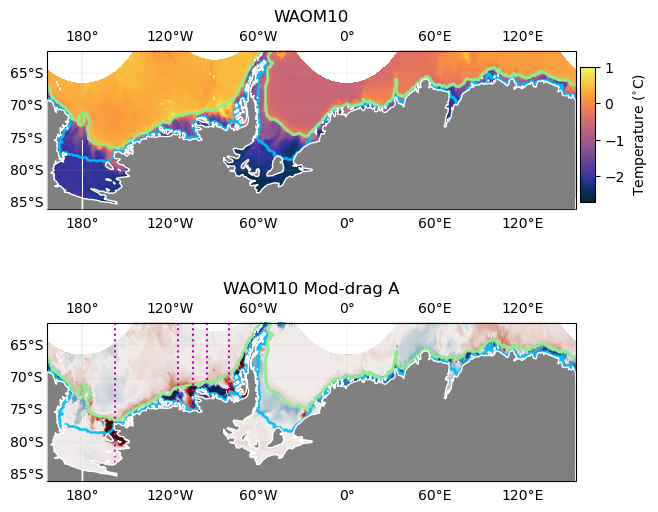

In [100]:
lon=-115 
lon_vector_115 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-105
lon_vector_105 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-80
lon_vector_80 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-95
lon_vector_95 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-158
lon_vector_158 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping


jst= 41
jen=-1
ist=0
ien=-1

tmin = -2.7
tmax = 1
atmin = -1
atmax = 1

# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')

ax1.gridlines(draw_labels=True,linewidth=.1)
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax1.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax0 = fig.add_axes([0.48, 0.695, 0.01, 0.135])
fig.colorbar(ct1, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Temperature ($^{\circ}$C)')#, labelpad=-35)

# ModDrag A
temp_diff = (temp.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (temp_mdA.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax2 = fig.add_subplot(323, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag A')
plt.plot(lon_vector_115,lat_vector, ':m', transform=ccrs.PlateCarree())
plt.plot(lon_vector_105,lat_vector, ':m', transform=ccrs.PlateCarree())
plt.plot(lon_vector_80,lat_vector, ':m', transform=ccrs.PlateCarree())
plt.plot(lon_vector_95,lat_vector, ':m', transform=ccrs.PlateCarree())
plt.plot(lon_vector_158,lat_vector, ':m', transform=ccrs.PlateCarree())


ax2.gridlines(draw_labels=True,linewidth=.1)
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax2.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .3
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)



In [ ]:
# Below old code doing separately. Will keep in case there's anything useful (06062024)

#### Create meridional transect, interpolate variables (T,U/V,DZT), and rotate velocities to get ONLY zonal component

AmudS

In [94]:
%%time

#Longitude = 115W

# 1) create vector (using lat.min:lat.max; then apply mask to remove values north of the 1500m isobath)
# vector should have same resolution as the original data (to minimise errors due to non-exact zonal transect)

minlat = -90
maxlat = -60

lat_maxpts = np.ceil(30/0.091985)
lat_vector = np.linspace(minlat,maxlat,num=int(lat_maxpts))

lon=-115 # west of PIT trough
lon_vector = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping

# Create a meshgrid from the longitude and latitude vectors
lon_mesh, lat_mesh = np.meshgrid(lon_vector, lat_vector)


# Create a new DataArray for the vector
vector_da = xr.DataArray(
    np.zeros_like(lon_mesh),  # Placeholder values (will be overwritten)
    dims=['lat_rho', 'lon_rho'],
    coords={'lat_rho': lat_vector, 'lon_rho': lon_vector}
)

##re-grid high-res zice/h to 10km grid:
w10_def = pyresample.geometry.SwathDefinition(lons=lon_rho_10km,lats=lat_rho_10km)
w10u_def = pyresample.geometry.SwathDefinition(lons=lon_u_10km,lats=lat_u_10km)
w10v_def = pyresample.geometry.SwathDefinition(lons=lon_v_10km,lats=lat_v_10km)
transect_def = pyresample.geometry.SwathDefinition(lons=vector_da.lon_rho,lats=vector_da.lat_rho)
wf = lambda r: 1/r

h_merid_transect = pyresample.kd_tree.resample_custom(w10_def,h_10km.values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)

## Find the index of the last point before depth >= 1500m -> to plot/calc only on the shelf --> NOT using this
last_pt_ind = np.where(h_merid_transect >= 1500)[0][0] - 1
last_pt_dep = h_merid_transect[last_pt_ind]
# The first point before depth > 500m
first_pt_ind = np.where(h_merid_transect > 50)[0][0] -1
first_pt_dep = h_merid_transect[first_pt_ind]

temp_merid_transect = np.empty((12,31,len(lon_vector)))
Hz_merid_transect = np.empty((12,31,len(lon_vector)))

lat_31lev = np.empty(Hz_merid_transect[0,:,:].shape)
for zz in range(31):
    lat_31lev[zz,:] = vector_da.lat_rho

for tt in range(0,12):
    for zz in range(0,31):
        temp_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,temp.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)
        Hz_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,z_rho.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)

lat_31lev_Lon115W = lat_31lev
temp_merid_transect_Lon115W = temp_merid_transect
Hz_merid_transect_Lon115W = Hz_merid_transect

CPU times: user 1min 38s, sys: 6.42 s, total: 1min 45s
Wall time: 4min 1s


In [77]:
%%time

#Longitude = 105W

# 1) create vector (using lat.min:lat.max; then apply mask to remove values north of the 1500m isobath)
# vector should have same resolution as the original data (to minimise errors due to non-exact zonal transect)

minlat = -90
maxlat = -60

lat_maxpts = np.ceil(30/0.091985)
lat_vector = np.linspace(minlat,maxlat,num=int(lat_maxpts))

lon=-105 # west of PIT trough
lon_vector = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping

# Create a meshgrid from the longitude and latitude vectors
lon_mesh, lat_mesh = np.meshgrid(lon_vector, lat_vector)


# Create a new DataArray for the vector
vector_da = xr.DataArray(
    np.zeros_like(lon_mesh),  # Placeholder values (will be overwritten)
    dims=['lat_rho', 'lon_rho'],
    coords={'lat_rho': lat_vector, 'lon_rho': lon_vector}
)

##re-grid high-res zice/h to 10km grid:
w10_def = pyresample.geometry.SwathDefinition(lons=lon_rho_10km,lats=lat_rho_10km)
w10u_def = pyresample.geometry.SwathDefinition(lons=lon_u_10km,lats=lat_u_10km)
w10v_def = pyresample.geometry.SwathDefinition(lons=lon_v_10km,lats=lat_v_10km)
transect_def = pyresample.geometry.SwathDefinition(lons=vector_da.lon_rho,lats=vector_da.lat_rho)
wf = lambda r: 1/r

h_merid_transect = pyresample.kd_tree.resample_custom(w10_def,h_10km.values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)

## Find the index of the last point before depth >= 1500m -> to plot/calc only on the shelf --> NOT using this
last_pt_ind = np.where(h_merid_transect >= 1500)[0][0] - 1
last_pt_dep = h_merid_transect[last_pt_ind]
# The first point before depth > 500m
first_pt_ind = np.where(h_merid_transect > 50)[0][0] -1
first_pt_dep = h_merid_transect[first_pt_ind]

temp_merid_transect = np.empty((12,31,len(lon_vector)))
Hz_merid_transect = np.empty((12,31,len(lon_vector)))

lat_31lev = np.empty(Hz_merid_transect[0,:,:].shape)
for zz in range(31):
    lat_31lev[zz,:] = vector_da.lat_rho

for tt in range(0,12):
    for zz in range(0,31):
        temp_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,temp.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)
        Hz_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,z_rho.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)

lat_31lev_Lon105W = lat_31lev
temp_merid_transect_Lon105W = temp_merid_transect
Hz_merid_transect_Lon105W = Hz_merid_transect

CPU times: user 1min 34s, sys: 6.2 s, total: 1min 40s
Wall time: 3min 49s


BellS

In [96]:
%%time

#Longitude = 80W

# 1) create vector (using lat.min:lat.max; then apply mask to remove values north of the 1500m isobath)
# vector should have same resolution as the original data (to minimise errors due to non-exact zonal transect)

minlat = -90
maxlat = -60

lat_maxpts = np.ceil(30/0.091985)
lat_vector = np.linspace(minlat,maxlat,num=int(lat_maxpts))

lon=-80 # west of PIT trough
lon_vector = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping

# Create a meshgrid from the longitude and latitude vectors
lon_mesh, lat_mesh = np.meshgrid(lon_vector, lat_vector)


# Create a new DataArray for the vector
vector_da = xr.DataArray(
    np.zeros_like(lon_mesh),  # Placeholder values (will be overwritten)
    dims=['lat_rho', 'lon_rho'],
    coords={'lat_rho': lat_vector, 'lon_rho': lon_vector}
)

##re-grid high-res zice/h to 10km grid:
w10_def = pyresample.geometry.SwathDefinition(lons=lon_rho_10km,lats=lat_rho_10km)
w10u_def = pyresample.geometry.SwathDefinition(lons=lon_u_10km,lats=lat_u_10km)
w10v_def = pyresample.geometry.SwathDefinition(lons=lon_v_10km,lats=lat_v_10km)
transect_def = pyresample.geometry.SwathDefinition(lons=vector_da.lon_rho,lats=vector_da.lat_rho)
wf = lambda r: 1/r

h_merid_transect = pyresample.kd_tree.resample_custom(w10_def,h_10km.values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)

## Find the index of the last point before depth >= 1500m -> to plot/calc only on the shelf --> NOT using this
last_pt_ind = np.where(h_merid_transect >= 1500)[0][0] - 1
last_pt_dep = h_merid_transect[last_pt_ind]
# The first point before depth > 500m
first_pt_ind = np.where(h_merid_transect > 50)[0][0] -1
first_pt_dep = h_merid_transect[first_pt_ind]

temp_merid_transect = np.empty((12,31,len(lon_vector)))
Hz_merid_transect = np.empty((12,31,len(lon_vector)))

lat_31lev = np.empty(Hz_merid_transect[0,:,:].shape)
for zz in range(31):
    lat_31lev[zz,:] = vector_da.lat_rho

for tt in range(0,12):
    for zz in range(0,31):
        temp_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,temp.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)
        Hz_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,z_rho.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)

lat_31lev_Lon80W = lat_31lev
temp_merid_transect_Lon80W = temp_merid_transect
Hz_merid_transect_Lon80W = Hz_merid_transect

CPU times: user 1min 45s, sys: 6.75 s, total: 1min 51s
Wall time: 4min 16s


In [97]:
%%time

#Longitude = 95W

# 1) create vector (using lat.min:lat.max; then apply mask to remove values north of the 1500m isobath)
# vector should have same resolution as the original data (to minimise errors due to non-exact zonal transect)

minlat = -90
maxlat = -60

lat_maxpts = np.ceil(30/0.091985)
lat_vector = np.linspace(minlat,maxlat,num=int(lat_maxpts))

lon=-95 # west of PIT trough
lon_vector = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping

# Create a meshgrid from the longitude and latitude vectors
lon_mesh, lat_mesh = np.meshgrid(lon_vector, lat_vector)


# Create a new DataArray for the vector
vector_da = xr.DataArray(
    np.zeros_like(lon_mesh),  # Placeholder values (will be overwritten)
    dims=['lat_rho', 'lon_rho'],
    coords={'lat_rho': lat_vector, 'lon_rho': lon_vector}
)

##re-grid high-res zice/h to 10km grid:
w10_def = pyresample.geometry.SwathDefinition(lons=lon_rho_10km,lats=lat_rho_10km)
w10u_def = pyresample.geometry.SwathDefinition(lons=lon_u_10km,lats=lat_u_10km)
w10v_def = pyresample.geometry.SwathDefinition(lons=lon_v_10km,lats=lat_v_10km)
transect_def = pyresample.geometry.SwathDefinition(lons=vector_da.lon_rho,lats=vector_da.lat_rho)
wf = lambda r: 1/r

h_merid_transect = pyresample.kd_tree.resample_custom(w10_def,h_10km.values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)

## Find the index of the last point before depth >= 1500m -> to plot/calc only on the shelf --> NOT using this
last_pt_ind = np.where(h_merid_transect >= 1500)[0][0] - 1
last_pt_dep = h_merid_transect[last_pt_ind]
# The first point before depth > 500m
first_pt_ind = np.where(h_merid_transect > 50)[0][0] -1
first_pt_dep = h_merid_transect[first_pt_ind]

temp_merid_transect = np.empty((12,31,len(lon_vector)))
Hz_merid_transect = np.empty((12,31,len(lon_vector)))

lat_31lev = np.empty(Hz_merid_transect[0,:,:].shape)
for zz in range(31):
    lat_31lev[zz,:] = vector_da.lat_rho

for tt in range(0,12):
    for zz in range(0,31):
        temp_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,temp.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)
        Hz_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,z_rho.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)

lat_31lev_Lon95W = lat_31lev
temp_merid_transect_Lon95W = temp_merid_transect
Hz_merid_transect_Lon95W = Hz_merid_transect

CPU times: user 1min 40s, sys: 6.92 s, total: 1min 47s
Wall time: 4min 24s


In [98]:
%%time

#Longitude = 158W

# 1) create vector (using lat.min:lat.max; then apply mask to remove values north of the 1500m isobath)
# vector should have same resolution as the original data (to minimise errors due to non-exact zonal transect)

minlat = -90
maxlat = -60

lat_maxpts = np.ceil(30/0.091985)
lat_vector = np.linspace(minlat,maxlat,num=int(lat_maxpts))

lon=-158 # west of PIT trough
lon_vector = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping

# Create a meshgrid from the longitude and latitude vectors
lon_mesh, lat_mesh = np.meshgrid(lon_vector, lat_vector)


# Create a new DataArray for the vector
vector_da = xr.DataArray(
    np.zeros_like(lon_mesh),  # Placeholder values (will be overwritten)
    dims=['lat_rho', 'lon_rho'],
    coords={'lat_rho': lat_vector, 'lon_rho': lon_vector}
)

##re-grid high-res zice/h to 10km grid:
w10_def = pyresample.geometry.SwathDefinition(lons=lon_rho_10km,lats=lat_rho_10km)
w10u_def = pyresample.geometry.SwathDefinition(lons=lon_u_10km,lats=lat_u_10km)
w10v_def = pyresample.geometry.SwathDefinition(lons=lon_v_10km,lats=lat_v_10km)
transect_def = pyresample.geometry.SwathDefinition(lons=vector_da.lon_rho,lats=vector_da.lat_rho)
wf = lambda r: 1/r

h_merid_transect = pyresample.kd_tree.resample_custom(w10_def,h_10km.values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)

## Find the index of the last point before depth >= 1500m -> to plot/calc only on the shelf --> NOT using this
last_pt_ind = np.where(h_merid_transect >= 1500)[0][0] - 1
last_pt_dep = h_merid_transect[last_pt_ind]
# The first point before depth > 500m
first_pt_ind = np.where(h_merid_transect > 50)[0][0] -1
first_pt_dep = h_merid_transect[first_pt_ind]

temp_merid_transect = np.empty((12,31,len(lon_vector)))
Hz_merid_transect = np.empty((12,31,len(lon_vector)))

lat_31lev = np.empty(Hz_merid_transect[0,:,:].shape)
for zz in range(31):
    lat_31lev[zz,:] = vector_da.lat_rho

for tt in range(0,12):
    for zz in range(0,31):
        temp_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,temp.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)
        Hz_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,z_rho.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)

lat_31lev_Lon158W = lat_31lev
temp_merid_transect_Lon158W = temp_merid_transect
Hz_merid_transect_Lon158W = Hz_merid_transect

CPU times: user 1min 43s, sys: 7.25 s, total: 1min 50s
Wall time: 4min 36s


In [95]:
## CREATE A FUNCTION to get the interpolation, then just give it 1 longitude as entry

# also add ALL experiments in each loop (ModDragA-D)

In [56]:
print(Hz_merid_transect.shape,temp_merid_transect.shape,lat_31lev.shape)

(1, 31, 327) (1, 31, 327) (31, 327)


Text(0.5, 1.0, 'Longitude 158W')

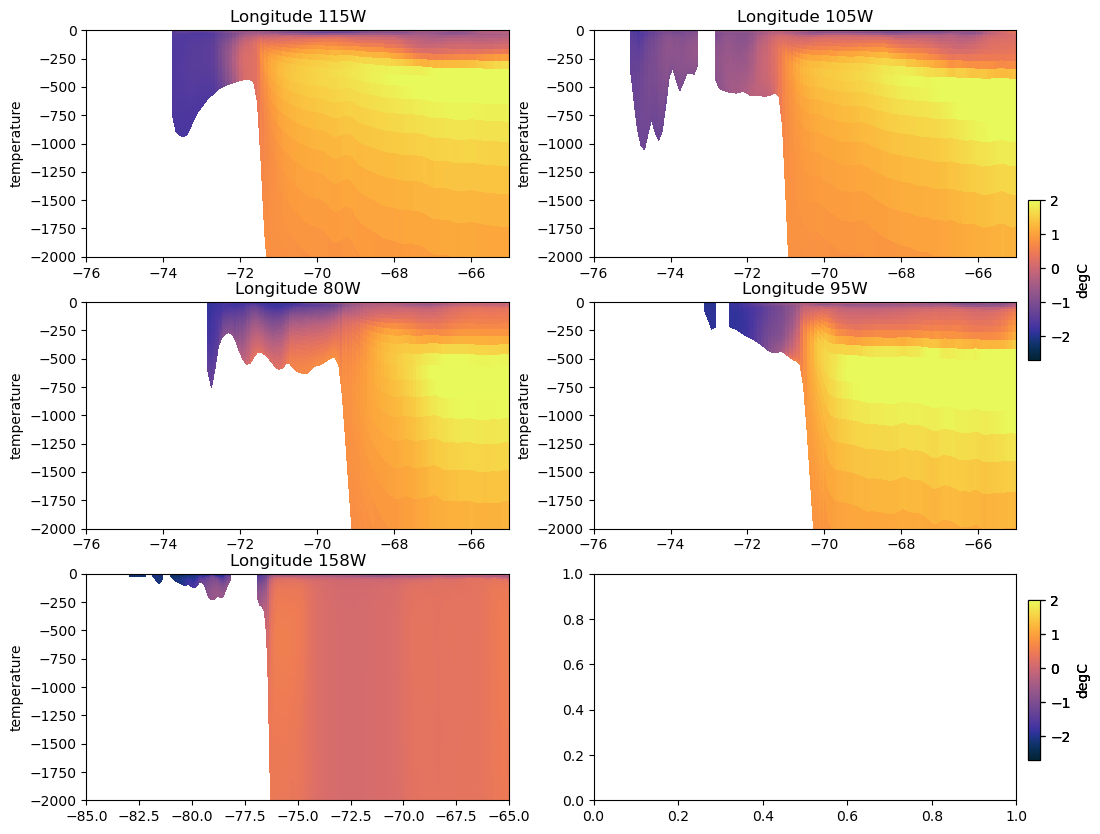

In [102]:
tmin=-2.7
tmax=2


fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (12, 10))

ct=ax[0,0].pcolor(lat_31lev_Lon115W,np.nanmean(Hz_merid_transect_Lon115W,axis=0),np.nanmean(temp_merid_transect_Lon115W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
cbar_ax0= fig.add_axes([0.91, 0.55,  0.01, 0.16])
fig.colorbar(ct, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('degC')#, labelpad=-35)
ax[0,0].set_ylabel('temperature')
ax[0,0].set_ylim(-2000,0)
ax[0,0].set_xlim(-76,-65)
ax[0,0].set_title('Longitude 115W')

ct=ax[0,1].pcolor(lat_31lev_Lon105W,np.nanmean(Hz_merid_transect_Lon105W,axis=0),np.nanmean(temp_merid_transect_Lon105W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
cbar_ax1= fig.add_axes([0.91, 0.15,  0.01, 0.16])
fig.colorbar(ct, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('degC')#, labelpad=-35)
ax[0,1].set_ylabel('temperature')
ax[0,1].set_ylim(-2000,0)
ax[0,1].set_xlim(-76,-65)
ax[0,1].set_title('Longitude 105W')

ct=ax[1,0].pcolor(lat_31lev_Lon80W,np.nanmean(Hz_merid_transect_Lon80W,axis=0),np.nanmean(temp_merid_transect_Lon80W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
cbar_ax0= fig.add_axes([0.91, 0.55,  0.01, 0.16])
fig.colorbar(ct, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('degC')#, labelpad=-35)
ax[1,0].set_ylabel('temperature')
ax[1,0].set_ylim(-2000,0)
ax[1,0].set_xlim(-76,-65)
ax[1,0].set_title('Longitude 80W')

ct=ax[1,1].pcolor(lat_31lev_Lon95W,np.nanmean(Hz_merid_transect_Lon95W,axis=0),np.nanmean(temp_merid_transect_Lon95W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
cbar_ax1= fig.add_axes([0.91, 0.15,  0.01, 0.16])
fig.colorbar(ct, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('degC')#, labelpad=-35)
ax[1,1].set_ylabel('temperature')
ax[1,1].set_ylim(-2000,0)
ax[1,1].set_xlim(-76,-65)
ax[1,1].set_title('Longitude 95W')

ct=ax[2,0].pcolor(lat_31lev_Lon158W,np.nanmean(Hz_merid_transect_Lon158W,axis=0),np.nanmean(temp_merid_transect_Lon158W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
cbar_ax1= fig.add_axes([0.91, 0.15,  0.01, 0.16])
fig.colorbar(ct, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('degC')#, labelpad=-35)
ax[2,0].set_ylabel('temperature')
ax[2,0].set_ylim(-2000,0)
ax[2,0].set_xlim(-85,-65)
ax[2,0].set_title('Longitude 158W')


## WHY NO CAVITY? 1. could be DZT calc, 2. could be Hz interp 

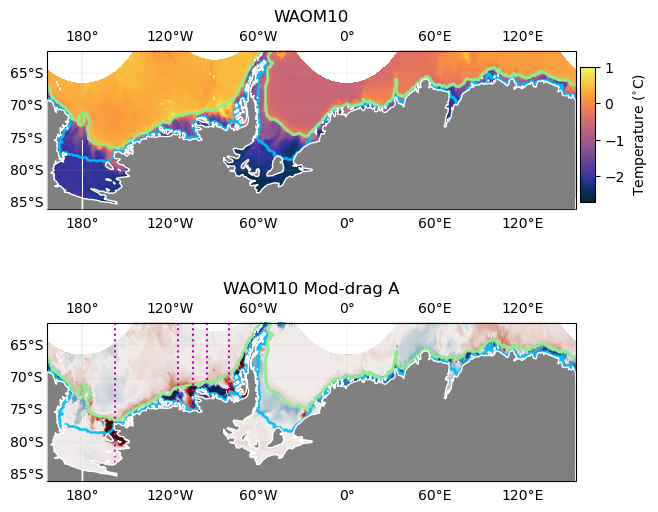

In [100]:
lon=-115 
lon_vector_115 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-105
lon_vector_105 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-80
lon_vector_80 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-95
lon_vector_95 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-158
lon_vector_158 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping


jst= 41
jen=-1
ist=0
ien=-1

tmin = -2.7
tmax = 1
atmin = -1
atmax = 1

# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')

ax1.gridlines(draw_labels=True,linewidth=.1)
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax1.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax0 = fig.add_axes([0.48, 0.695, 0.01, 0.135])
fig.colorbar(ct1, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Temperature ($^{\circ}$C)')#, labelpad=-35)

# ModDrag A
temp_diff = (temp.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15) - (temp_mdA.isel(s_rho=0,xi_rho=slice(ist,ien),eta_rho=slice(jst,jen)).mean('ocean_time')+273.15)
ax2 = fig.add_subplot(323, projection=proj)
cta=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,
                   temp_diff, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Mod-drag A')
plt.plot(lon_vector_115,lat_vector, ':m', transform=ccrs.PlateCarree())
plt.plot(lon_vector_105,lat_vector, ':m', transform=ccrs.PlateCarree())
plt.plot(lon_vector_80,lat_vector, ':m', transform=ccrs.PlateCarree())
plt.plot(lon_vector_95,lat_vector, ':m', transform=ccrs.PlateCarree())
plt.plot(lon_vector_158,lat_vector, ':m', transform=ccrs.PlateCarree())


ax2.gridlines(draw_labels=True,linewidth=.1)
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax2.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .3
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

